# Chronos Bolt on MUSEval using run_museval Functions

This notebook demonstrates how to run Chronos Bolt on the MUSEval benchmark using the functions from `run_museval.py`. This simplifies the outputs to make easier 

In [1]:
import os
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from typing import Optional

# Import MUSEval components
from museval.data import Benchmark
from museval.metrics import MAPE, MAE, RMSE, NMAE

# Import functions from the examples package
from museval.examples import (
    run_models_on_benchmark, 
    compare_model_performance, 
    export_hierarchical_results_to_csv
)

print("MUSEval components imported successfully!")


MUSEval components imported successfully!


In [2]:
class ChronosForecast:
    """
    Chronos forecasting model wrapper for MUSED-FM evaluation.
    """
    
    def __init__(self, model_path: str = "amazon/chronos-bolt-base", device: str = "cuda:0", num_samples: int = 20):
        """
        Initialize Chronos forecast model.
        
        Args:
            model_path: Path to Chronos model (HuggingFace model ID or local path)
            device: Device to run the model on
            num_samples: Number of samples for probabilistic forecasting
        """
        self.model_path = model_path
        self.device = device
        self.num_samples = num_samples
        self.pipeline = None
        self._load_model()
    
    def _load_model(self):
        """Load the Chronos model."""
        try:
            from chronos import BaseChronosPipeline, ForecastType
            
            self.pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
                self.model_path,
                device_map=self.device,
            )
            print(f"Loaded Chronos model: {self.model_path}")
        except ImportError:
            raise ImportError("Chronos package not installed. Please install with: pip install chronos-forecasting")
        except Exception as e:
            raise RuntimeError(f"Failed to load Chronos model: {e}")
    
    def forecast(self, history: np.ndarray, covariates: Optional[np.ndarray] = None, forecast_horizon: Optional[int] = None, timestamps: Optional[np.ndarray] = None) -> np.ndarray:
        """
        Generate forecast from historical data using Chronos.
        
        Args:
            history: Historical time series data (shape: [batch_size, history_length])
            covariates: Optional covariate data (ignored for Chronos)
            forecast_horizon: Number of future points to forecast (default: 1)
            timestamps: Optional timestamp data (ignored for Chronos)
            
        Returns:
            Forecast values (shape: [batch_size, forecast_horizon])
        """
        if forecast_horizon is None:
            forecast_horizon = 1
        
        # Vectorized normalization across the batch
        history_mean = np.nanmean(history, axis=1, keepdims=True)  # [batch_size, 1]
        history_std = np.nanstd(history, axis=1, keepdims=True)    # [batch_size, 1]
        history_normalized = (history - history_mean) / np.maximum(history_std, 1e-10)
        
        # Convert to torch tensor and handle NaNs
        history_tensor = torch.tensor(history_normalized, dtype=torch.float32)
        history_tensor = torch.nan_to_num(history_tensor, nan=0.0)
        
        # Generate forecast (Chronos accepts 2D tensor directly)
        forecast_output = self.pipeline.predict(
            history_tensor,
            prediction_length=forecast_horizon
        )
        
        # Convert to numpy array
        if isinstance(forecast_output, torch.Tensor):
            forecast_np = forecast_output.detach().cpu().numpy()
        else:
            forecast_np = np.array(forecast_output)
        
        # Handle quantile output - take median (index 4 for 9 quantiles)
        if forecast_np.ndim == 3 and forecast_np.shape[1] == 9:
            forecast_np = forecast_np[:, 4, :]  # [batch_size, prediction_length]
        
        # Ensure correct length
        if forecast_np.shape[1] != forecast_horizon:
            if forecast_np.shape[1] > forecast_horizon:
                forecast_np = forecast_np[:, :forecast_horizon]
            else:
                # Pad with last value
                last_values = forecast_np[:, -1:]  # [batch_size, 1]
                padding_length = forecast_horizon - forecast_np.shape[1]
                padding = np.repeat(last_values, padding_length, axis=1)
                forecast_np = np.concatenate([forecast_np, padding], axis=1)
        
        # Denormalize
        forecast_np = forecast_np * history_std + history_mean
        
        return forecast_np


In [3]:
# Configuration
BENCHMARK_PATH = "../../museval-nested/"  # Adjust this path to your MUSEval data
MODEL_PATH = "amazon/chronos-bolt-base"  # Chronos Bolt model
DEVICE = "cuda:0"  # Use "cpu" if you don't have CUDA
NUM_SAMPLES = 20  # Number of samples for probabilistic forecasting
MAX_WINDOWS = 2  # Limit windows per dataset for faster testing
OUTPUT_DIR = "../../museval_runs/chronos_bolt"

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Benchmark path: {BENCHMARK_PATH}")
print(f"Model: {MODEL_PATH}")
print(f"Device: {DEVICE}")
print(f"Output directory: {OUTPUT_DIR}")


Benchmark path: ../../museval-nested/
Model: amazon/chronos-bolt-base
Device: cuda:0
Output directory: ../../museval_runs/chronos_bolt


In [4]:
# Initialize Chronos model
try:
    chronos_model = ChronosForecast(
        model_path=MODEL_PATH,
        device=DEVICE,
        num_samples=NUM_SAMPLES
    )
    print("Chronos model initialized successfully!")
except Exception as e:
    print(f"Error initializing Chronos model: {e}")
    print("Make sure you have installed chronos-forecasting and have the required dependencies.")


Loaded Chronos model: amazon/chronos-bolt-base
Chronos model initialized successfully!


In [5]:
# Suppress Chronos prediction length warnings
import warnings
warnings.filterwarnings("ignore", 
                       message="We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it.",
                       category=UserWarning,
                       module="chronos")

# Suppress all Chronos warnings
warnings.filterwarnings("ignore", 
                       module="chronos")


In [6]:
# Import plotting utilities
import matplotlib.pyplot as plt
from museval.plotting import plot_window_forecasts, plot_multiple_windows, plot_baseline_comparison

# Run Chronos evaluation with plot data collection (one window per dataset)
print("Starting Chronos evaluation with plot data collection...")

# Define models dictionary (same format as run_museval.py)
models = {
    "chronos": {"model": chronos_model, "univariate": True}
}

# Run evaluation using the efficient run_museval function with plot data collection
results = run_models_on_benchmark(
    benchmark_path=BENCHMARK_PATH,
    models=models,
    max_windows=MAX_WINDOWS,
    history_length=512,
    forecast_horizon=128,
    stride=256,
    load_cached_counts=True,
    collect_plot_data=True  # Enable plot data collection
)

print("Evaluation completed successfully!")

# Use plot data directly from results
if '_plot_data' in results:
    plot_data = results['_plot_data']
    print(f"\nUsing {len(plot_data)} windows directly from results for plotting")
    print("Plot data ready for visualization!")
else:
    print("No plot data collected during evaluation.")

Starting Chronos evaluation with plot data collection...
Running Multiple Models on Benchmark
Loading KITTI data from ../../museval-nested/sequential/KITTI
Found 6114 parquet files
Successfully loaded 6114 valid files
Domain ALL_DATASETS not found in file hierarchy
loading window counts from ../../museval-nested/sequential_window_counts_h512_f128_s256.json
loaded 8 cached window counts for category sequential
['hopper_csv_out', 'spriteworld', 'ant_csv_out', 'cheetah_csv_out', 'walker2d_csv_out', 'KITTI', 'openwebtext_timeseries_csvs', 'cifar100_timeseries_csvs']
successfully counted windows from cached JSON files
Loading ECL data from ../../museval-nested/traditional/ecl
Found 1 parquet files
Successfully loaded 206 valid chunks
Domain ALL_DATASETS not found in file hierarchy
loading window counts from ../../museval-nested/traditional_window_counts_h512_f128_s256.json
loaded 70 cached window counts for category traditional
['fl_electricity', 'ny_electricity2025', 'ecl', 'aus_electricit

Processing datasets:   0%|          | 0/86 [00:00<?, ?dataset/s, Processing: hopper_csv_out]

  Processing 2 windows with 1 models...


Processing datasets:   1%|          | 1/86 [00:00<00:31,  2.70dataset/s, Processing: spriteworld]   

  Completed dataset hopper_csv_out with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:   2%|▏         | 2/86 [00:00<00:31,  2.70dataset/s, Processing: ant_csv_out]

  Completed dataset spriteworld with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:   3%|▎         | 3/86 [00:00<00:12,  6.85dataset/s, Processing: cheetah_csv_out]

  Completed dataset ant_csv_out with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:   5%|▍         | 4/86 [00:00<00:11,  6.85dataset/s, Processing: walker2d_csv_out]

  Completed dataset cheetah_csv_out with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:   6%|▌         | 5/86 [00:00<00:08,  9.32dataset/s, Processing: KITTI]           

  Completed dataset walker2d_csv_out with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:   7%|▋         | 6/86 [00:00<00:08,  9.32dataset/s, Processing: openwebtext_timeseries_csvs]

  Completed dataset KITTI with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:   8%|▊         | 7/86 [00:00<00:07, 10.58dataset/s, Processing: cifar100_timeseries_csvs]   

  Completed dataset openwebtext_timeseries_csvs with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:   9%|▉         | 8/86 [00:00<00:07, 10.58dataset/s, Processing: fl_electricity]          

  Completed dataset cifar100_timeseries_csvs with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  10%|█         | 9/86 [00:00<00:06, 12.04dataset/s, Processing: ny_electricity2025]

  Completed dataset fl_electricity with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  12%|█▏        | 10/86 [00:01<00:06, 12.04dataset/s, Processing: ecl]              

  Completed dataset ny_electricity2025 with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  13%|█▎        | 11/86 [00:01<00:05, 12.56dataset/s, Processing: aus_electricity_qld]

  Completed dataset ecl with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  14%|█▍        | 12/86 [00:01<00:05, 12.56dataset/s, Processing: central_electricity]

  Completed dataset aus_electricity_qld with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  15%|█▌        | 13/86 [00:01<00:07,  9.73dataset/s, Processing: eastern_electricity]

  Completed dataset central_electricity with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  16%|█▋        | 14/86 [00:01<00:07,  9.73dataset/s, Processing: northern_electricity]

  Completed dataset eastern_electricity with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  17%|█▋        | 15/86 [00:01<00:07,  9.73dataset/s, Processing: southern_electricity]

  Completed dataset northern_electricity with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  19%|█▊        | 16/86 [00:01<00:05, 12.49dataset/s, Processing: western_electricity] 

  Completed dataset southern_electricity with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  20%|█▉        | 17/86 [00:01<00:05, 12.49dataset/s, Processing: az_electricity]     

  Completed dataset western_electricity with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  21%|██        | 18/86 [00:01<00:04, 13.61dataset/s, Processing: id_electricity]

  Completed dataset az_electricity with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  22%|██▏       | 19/86 [00:01<00:04, 13.61dataset/s, Processing: pa_electricity]

  Completed dataset id_electricity with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  23%|██▎       | 20/86 [00:01<00:04, 13.73dataset/s, Processing: tx_electricity]

  Completed dataset pa_electricity with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  24%|██▍       | 21/86 [00:01<00:04, 13.73dataset/s, Processing: cal_electricity]

  Completed dataset tx_electricity with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  26%|██▌       | 22/86 [00:01<00:04, 13.90dataset/s, Processing: ne_electricity] 

  Completed dataset cal_electricity with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  27%|██▋       | 23/86 [00:01<00:04, 13.90dataset/s, Processing: se_electricity]

  Completed dataset ne_electricity with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  28%|██▊       | 24/86 [00:02<00:04, 14.05dataset/s, Processing: car_electricity]

  Completed dataset se_electricity with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  29%|██▉       | 25/86 [00:02<00:04, 14.05dataset/s, Processing: or_electricity] 

  Completed dataset car_electricity with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  30%|███       | 26/86 [00:02<00:04, 14.27dataset/s, Processing: tn_electricity]

  Completed dataset or_electricity with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  31%|███▏      | 27/86 [00:02<00:04, 14.27dataset/s, Processing: al_daily]      

  Completed dataset tn_electricity with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  33%|███▎      | 28/86 [00:02<00:03, 14.62dataset/s, Processing: az_daily]

  Completed dataset al_daily with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  34%|███▎      | 29/86 [00:02<00:03, 14.62dataset/s, Processing: cal_daily]

  Completed dataset az_daily with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  35%|███▍      | 30/86 [00:02<00:03, 15.43dataset/s, Processing: car_daily]

  Completed dataset cal_daily with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  36%|███▌      | 31/86 [00:02<00:03, 15.43dataset/s, Processing: co_daily] 

  Completed dataset car_daily with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  37%|███▋      | 32/86 [00:02<00:03, 15.95dataset/s, Processing: ne_daily]

  Completed dataset co_daily with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  38%|███▊      | 33/86 [00:02<00:03, 15.95dataset/s, Processing: nm_daily]

  Completed dataset ne_daily with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  40%|███▉      | 34/86 [00:02<00:03, 15.41dataset/s, Processing: ny_daily]

  Completed dataset nm_daily with 2 windows
  Processing 2 windows with 1 models...


  Completed dataset ny_daily with 2 windows


Processing datasets:  41%|████      | 35/86 [00:02<00:03, 15.41dataset/s, Processing: pa_daily]

  Processing 2 windows with 1 models...


Processing datasets:  42%|████▏     | 36/86 [00:02<00:03, 15.72dataset/s, Processing: tn_daily]

  Completed dataset pa_daily with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  43%|████▎     | 37/86 [00:02<00:03, 15.72dataset/s, Processing: tx_daily]

  Completed dataset tn_daily with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  44%|████▍     | 38/86 [00:02<00:03, 15.66dataset/s, Processing: ercot_load]

  Completed dataset tx_daily with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  45%|████▌     | 39/86 [00:03<00:03, 15.66dataset/s, Processing: aus_electricity_nsw]

  Completed dataset ercot_load with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  47%|████▋     | 40/86 [00:03<00:04, 10.02dataset/s, Processing: solar_alabama]      

  Completed dataset aus_electricity_nsw with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  48%|████▊     | 41/86 [00:03<00:04, 10.02dataset/s, Processing: mds_microgrid]

  Completed dataset solar_alabama with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  49%|████▉     | 42/86 [00:03<00:05,  7.43dataset/s, Processing: voip]         

  Completed dataset mds_microgrid with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  50%|█████     | 43/86 [00:03<00:05,  7.43dataset/s, Processing: ev-sensors]

  Completed dataset voip with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  51%|█████     | 44/86 [00:04<00:07,  5.81dataset/s, Processing: austin_water]

  Completed dataset ev-sensors with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  52%|█████▏    | 45/86 [00:04<00:07,  5.81dataset/s, Processing: mn_interstate]

  Completed dataset austin_water with 1 windows
  Processing 2 windows with 1 models...


Processing datasets:  53%|█████▎    | 46/86 [00:04<00:05,  6.86dataset/s, Processing: blue_bikes]   

  Completed dataset mn_interstate with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  55%|█████▍    | 47/86 [00:04<00:06,  5.80dataset/s, Processing: cursor-tabs]

  Completed dataset blue_bikes with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  56%|█████▌    | 48/86 [00:04<00:06,  5.80dataset/s, Processing: traffic_PeMS]

  Completed dataset cursor-tabs with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  57%|█████▋    | 49/86 [00:04<00:05,  7.22dataset/s, Processing: tac]         

  Completed dataset traffic_PeMS with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  58%|█████▊    | 50/86 [00:04<00:04,  7.22dataset/s, Processing: paris_mobility]

  Completed dataset tac with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  59%|█████▉    | 51/86 [00:05<00:04,  7.95dataset/s, Processing: mta_ridership] 

  Completed dataset paris_mobility with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  60%|██████    | 52/86 [00:05<00:04,  7.95dataset/s, Processing: lyft]         

  Completed dataset mta_ridership with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  62%|██████▏   | 53/86 [00:05<00:03,  9.26dataset/s, Processing: uber]

  Completed dataset lyft with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  63%|██████▎   | 54/86 [00:05<00:03,  9.26dataset/s, Processing: gas_sensor]

  Completed dataset uber with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  64%|██████▍   | 55/86 [00:06<00:10,  2.90dataset/s, Processing: oikolab_weather]

  Completed dataset gas_sensor with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  65%|██████▌   | 56/86 [00:07<00:09,  3.22dataset/s, Processing: open_aq]        

  Completed dataset oikolab_weather with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  66%|██████▋   | 57/86 [00:07<00:08,  3.22dataset/s, Processing: beijing_embassy]

  Completed dataset open_aq with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  67%|██████▋   | 58/86 [00:07<00:07,  3.73dataset/s, Processing: causalrivers]   

  Completed dataset beijing_embassy with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  69%|██████▊   | 59/86 [00:07<00:07,  3.42dataset/s, Processing: weather_mpi] 

  Completed dataset causalrivers with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  70%|██████▉   | 60/86 [00:07<00:07,  3.42dataset/s, Processing: beijing_aq] 

  Completed dataset weather_mpi with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  71%|███████   | 61/86 [00:18<00:52,  2.11s/dataset, Processing: walmart-sales]

Skipping window with completely NaN target: 15360
  Completed dataset beijing_aq with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  72%|███████▏  | 62/86 [00:18<00:50,  2.11s/dataset, Processing: gold_prices]  

  Completed dataset walmart-sales with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  73%|███████▎  | 63/86 [00:18<00:32,  1.42s/dataset, Processing: bitcoin_price]

  Completed dataset gold_prices with 1 windows
  Processing 2 windows with 1 models...


Processing datasets:  74%|███████▍  | 64/86 [00:18<00:31,  1.42s/dataset, Processing: rice_prices]  

  Completed dataset bitcoin_price with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  76%|███████▌  | 65/86 [00:18<00:20,  1.02dataset/s, Processing: pasta_sales]

  Completed dataset rice_prices with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  77%|███████▋  | 66/86 [00:18<00:19,  1.02dataset/s, Processing: blow_molding]

  Completed dataset pasta_sales with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  78%|███████▊  | 67/86 [00:18<00:13,  1.46dataset/s, Processing: sleep_lab]   

  Completed dataset blow_molding with 1 windows
  Processing 2 windows with 1 models...


Processing datasets:  79%|███████▉  | 68/86 [00:19<00:12,  1.46dataset/s, Processing: cgm]      

  Completed dataset sleep_lab with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  80%|████████  | 69/86 [00:19<00:08,  2.02dataset/s, Processing: fred_md1]

  Completed dataset cgm with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  81%|████████▏ | 70/86 [00:19<00:07,  2.02dataset/s, Processing: fred_md2]

  Completed dataset fred_md1 with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  83%|████████▎ | 71/86 [00:19<00:05,  2.74dataset/s, Processing: fred_md3]

  Completed dataset fred_md2 with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  84%|████████▎ | 72/86 [00:19<00:05,  2.74dataset/s, Processing: fred_md4]

  Completed dataset fred_md3 with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  85%|████████▍ | 73/86 [00:19<00:03,  3.64dataset/s, Processing: fred_md5]

  Completed dataset fred_md4 with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  86%|████████▌ | 74/86 [00:19<00:03,  3.64dataset/s, Processing: fred_md6]

  Completed dataset fred_md5 with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  87%|████████▋ | 75/86 [00:19<00:02,  4.69dataset/s, Processing: fred_md7]

  Completed dataset fred_md6 with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  88%|████████▊ | 76/86 [00:19<00:02,  4.69dataset/s, Processing: fred_md8]

  Completed dataset fred_md7 with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  90%|████████▉ | 77/86 [00:19<00:01,  5.88dataset/s, Processing: website_visitors]

  Completed dataset fred_md8 with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  91%|█████████ | 78/86 [00:19<00:01,  5.88dataset/s, Processing: large_convlag_synin_s]

  Completed dataset website_visitors with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  92%|█████████▏| 79/86 [00:19<00:00,  7.01dataset/s, Processing: medium_convlag_synin_s]

  Completed dataset large_convlag_synin_s with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  93%|█████████▎| 80/86 [00:19<00:00,  7.01dataset/s, Processing: medium_obslag_synin_s] 

  Completed dataset medium_convlag_synin_s with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  94%|█████████▍| 81/86 [00:19<00:00,  8.25dataset/s, Processing: tiny_convlag_synin_ns]

  Completed dataset medium_obslag_synin_s with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  95%|█████████▌| 82/86 [00:20<00:00,  8.25dataset/s, Processing: tiny_obslag_synin_ns] 

  Completed dataset tiny_convlag_synin_ns with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  97%|█████████▋| 83/86 [00:20<00:00,  9.39dataset/s, Processing: dynamic_data_csvs]   

  Completed dataset tiny_obslag_synin_ns with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  98%|█████████▊| 84/86 [00:20<00:00,  9.39dataset/s, Processing: wikipedia]        

  Completed dataset dynamic_data_csvs with 2 windows
  Processing 2 windows with 1 models...


Processing datasets:  99%|█████████▉| 85/86 [00:20<00:00, 10.80dataset/s, Processing: stock_nasdaqtrader]

  Completed dataset wikipedia with 2 windows
  Processing 2 windows with 1 models...


Processing datasets: 100%|██████████| 86/86 [00:20<00:00,  4.23dataset/s, Processing: stock_nasdaqtrader]

  Completed dataset stock_nasdaqtrader with 2 windows
Evaluation completed successfully!

Using 86 windows directly from results for plotting
Plot data ready for visualization!


In [7]:
# Compare model performance
compare_model_performance(results)



Model Performance Comparison
Model                MAPE (%)   MAE        RMSE       NMAE       Time (s)  
--------------------------------------------------------------------------------
chronos              79.35      3704876.9923 4591719.0858 0.9195     20.19     

Best Performance:
  Lowest MAPE: chronos (79.35%)
  Lowest MAE:  chronos (3704876.9923)
  Lowest RMSE: chronos (4591719.0858)
  Fastest:     chronos (20.19s)



Generating Forecast Metrics CSV
Creating individual forecast plots...
['window', 'forecast', 'univariate_forecast', 'model_name', 'window_index', 'dataset_name']
Started Processing hopper_csv_out - Window 0
Started Processing spriteworld - Window 1
Plot saved to: ../../museval_runs/chronos_bolt/plots/baseline_forecast_1.png


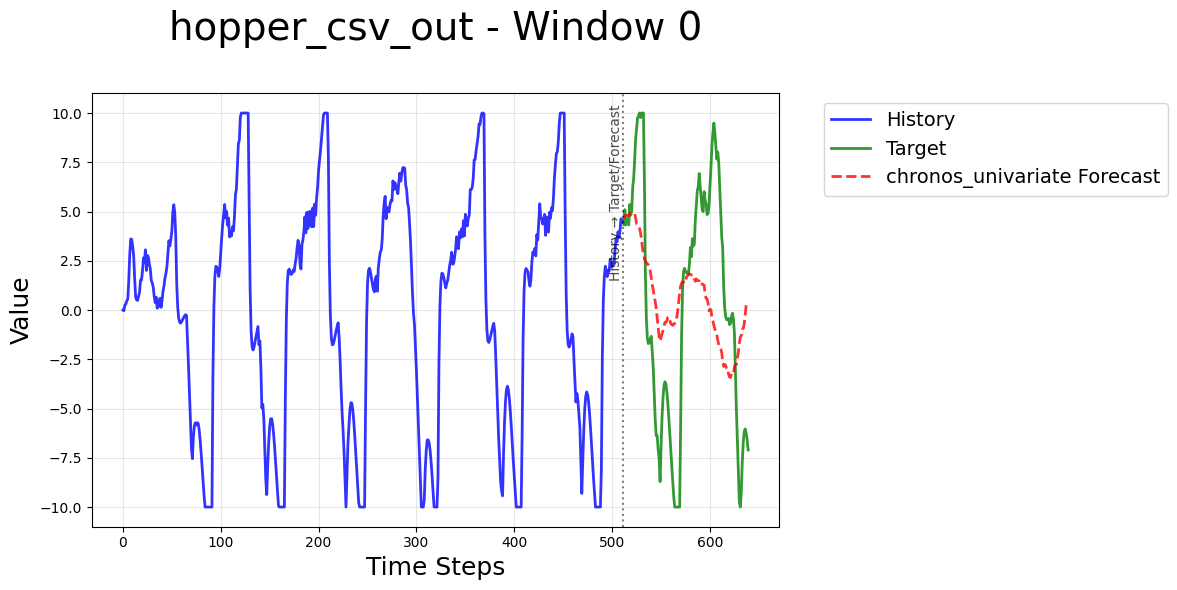

Saved plot 2: spriteworld - Window 1 to ../../museval_runs/chronos_bolt/plots/baseline_forecast_1.png
Started Processing ant_csv_out - Window 2
Plot saved to: ../../museval_runs/chronos_bolt/plots/baseline_forecast_2.png


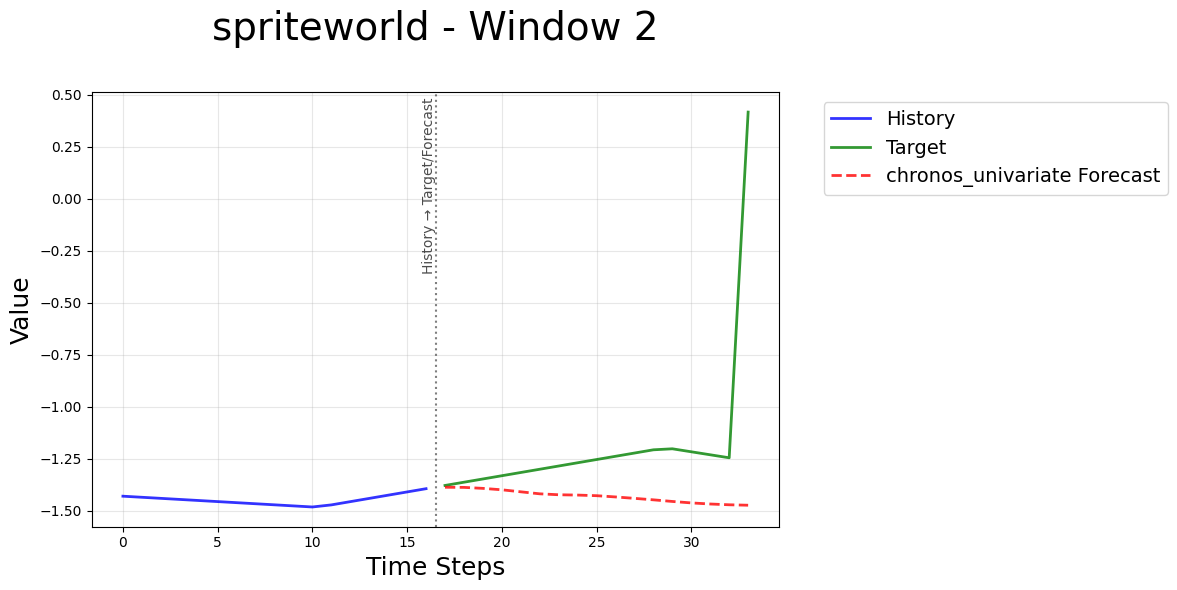

Saved plot 3: ant_csv_out - Window 2 to ../../museval_runs/chronos_bolt/plots/baseline_forecast_2.png
Started Processing cheetah_csv_out - Window 3
Plot saved to: ../../museval_runs/chronos_bolt/plots/baseline_forecast_3.png


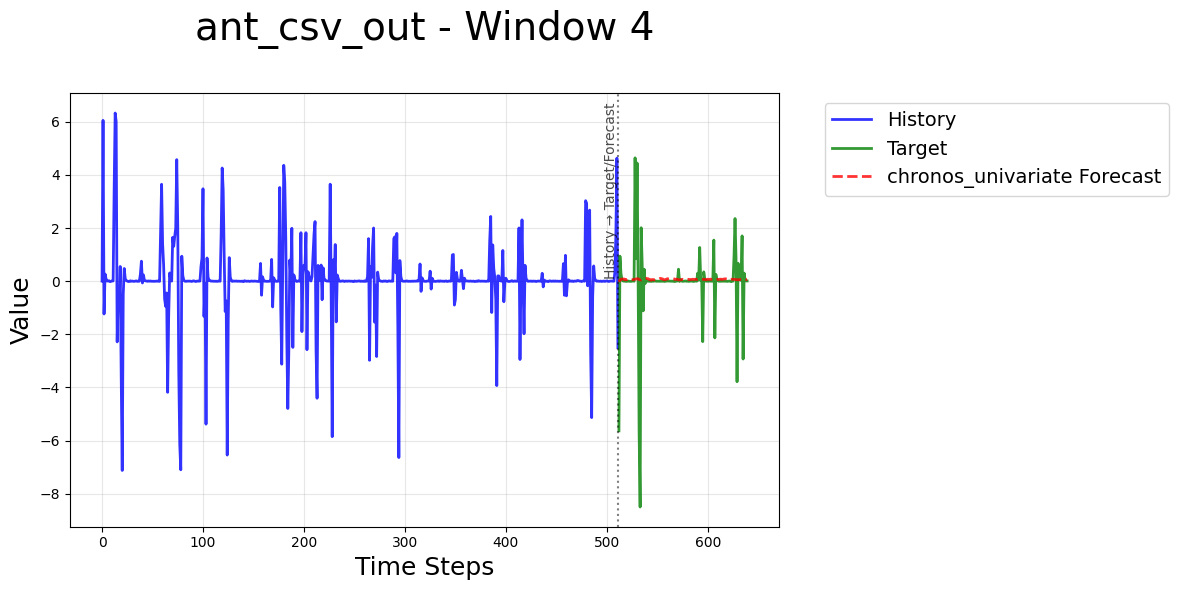

Saved plot 4: cheetah_csv_out - Window 3 to ../../museval_runs/chronos_bolt/plots/baseline_forecast_3.png
Started Processing walker2d_csv_out - Window 4
Plot saved to: ../../museval_runs/chronos_bolt/plots/baseline_forecast_4.png


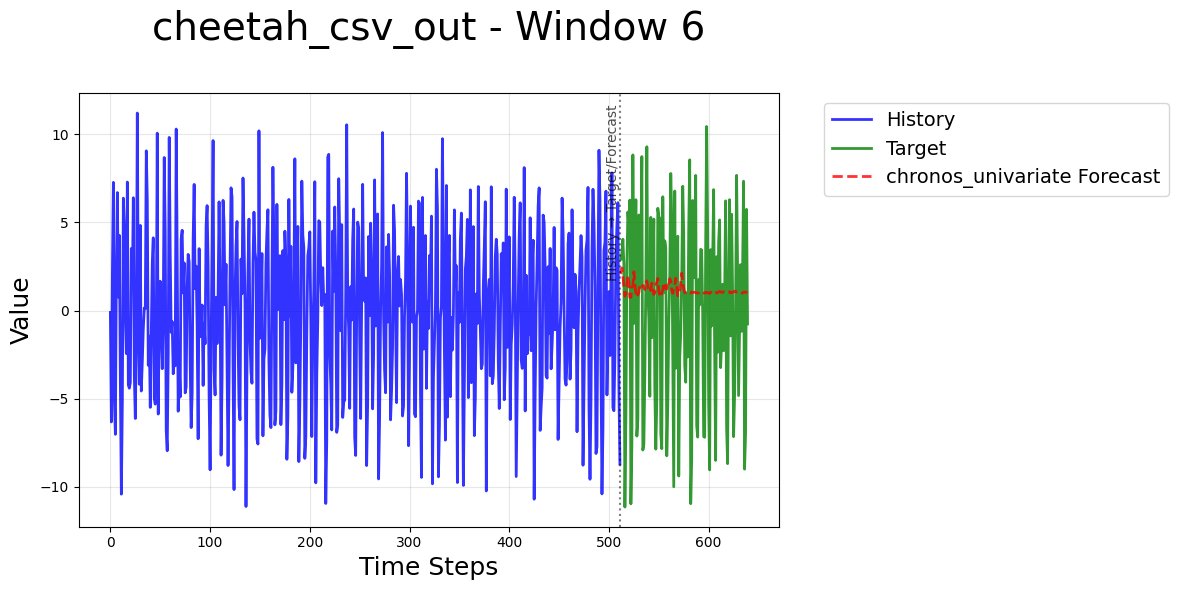

Saved plot 5: walker2d_csv_out - Window 4 to ../../museval_runs/chronos_bolt/plots/baseline_forecast_4.png
Started Processing KITTI - Window 5
Plot saved to: ../../museval_runs/chronos_bolt/plots/baseline_forecast_5.png


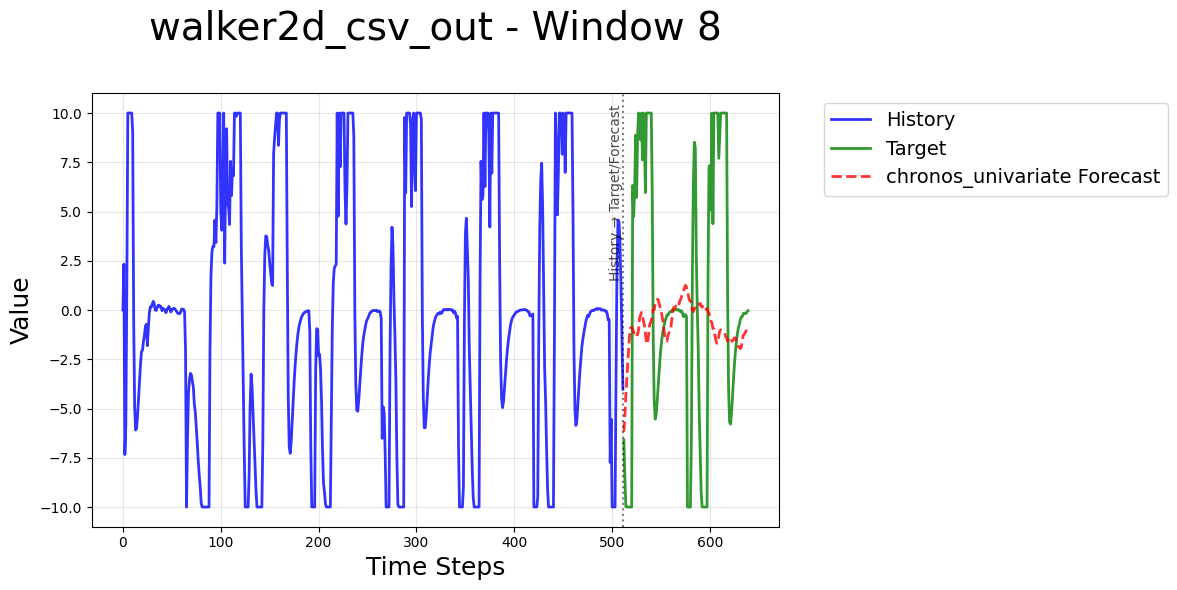

Saved plot 6: KITTI - Window 5 to ../../museval_runs/chronos_bolt/plots/baseline_forecast_5.png
Started Processing openwebtext_timeseries_csvs - Window 6
Plot saved to: ../../museval_runs/chronos_bolt/plots/baseline_forecast_6.png


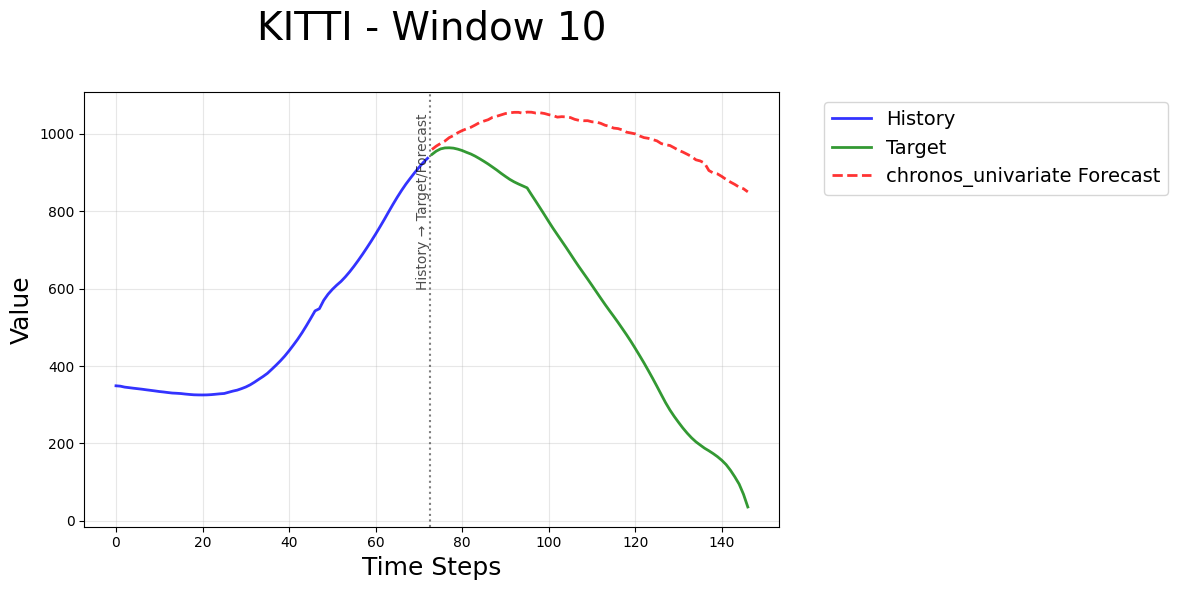

Saved plot 7: openwebtext_timeseries_csvs - Window 6 to ../../museval_runs/chronos_bolt/plots/baseline_forecast_6.png
Started Processing cifar100_timeseries_csvs - Window 7
Plot saved to: ../../museval_runs/chronos_bolt/plots/baseline_forecast_7.png


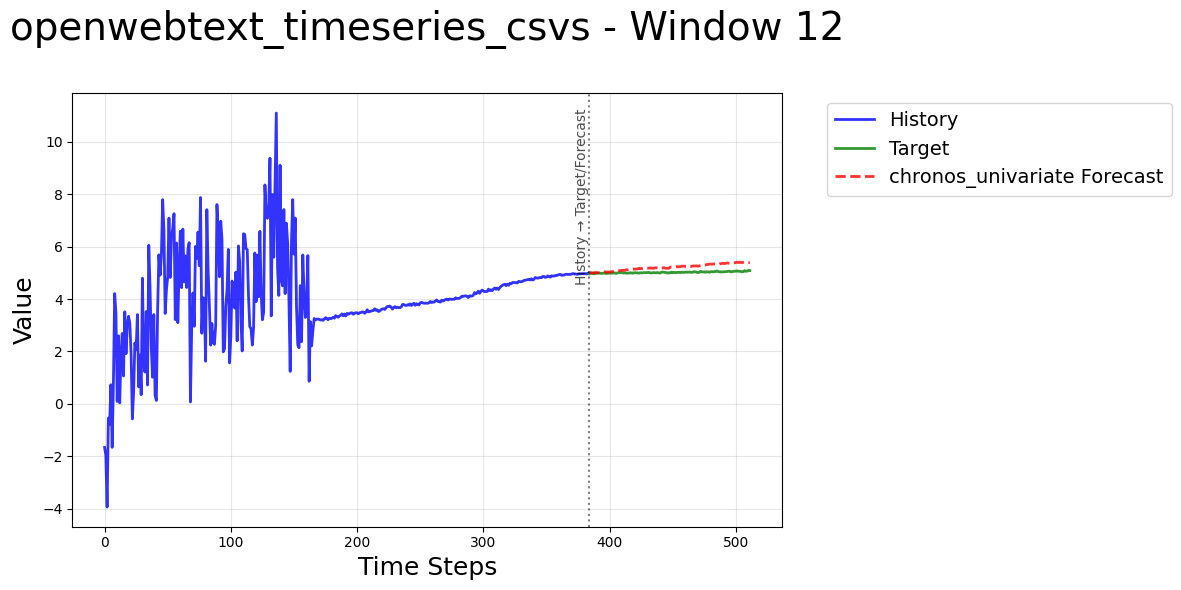

Saved plot 8: cifar100_timeseries_csvs - Window 7 to ../../museval_runs/chronos_bolt/plots/baseline_forecast_7.png
Started Processing fl_electricity - Window 8
Plot saved to: ../../museval_runs/chronos_bolt/plots/baseline_forecast_8.png


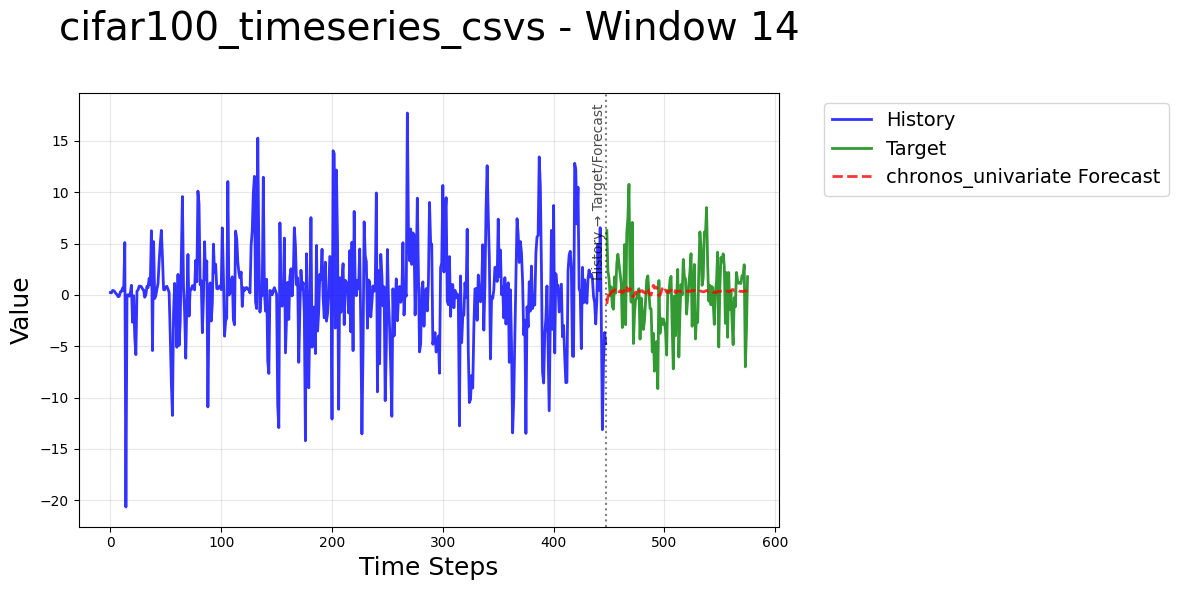

Saved plot 9: fl_electricity - Window 8 to ../../museval_runs/chronos_bolt/plots/baseline_forecast_8.png
Started Processing ny_electricity2025 - Window 9
Plot saved to: ../../museval_runs/chronos_bolt/plots/baseline_forecast_9.png


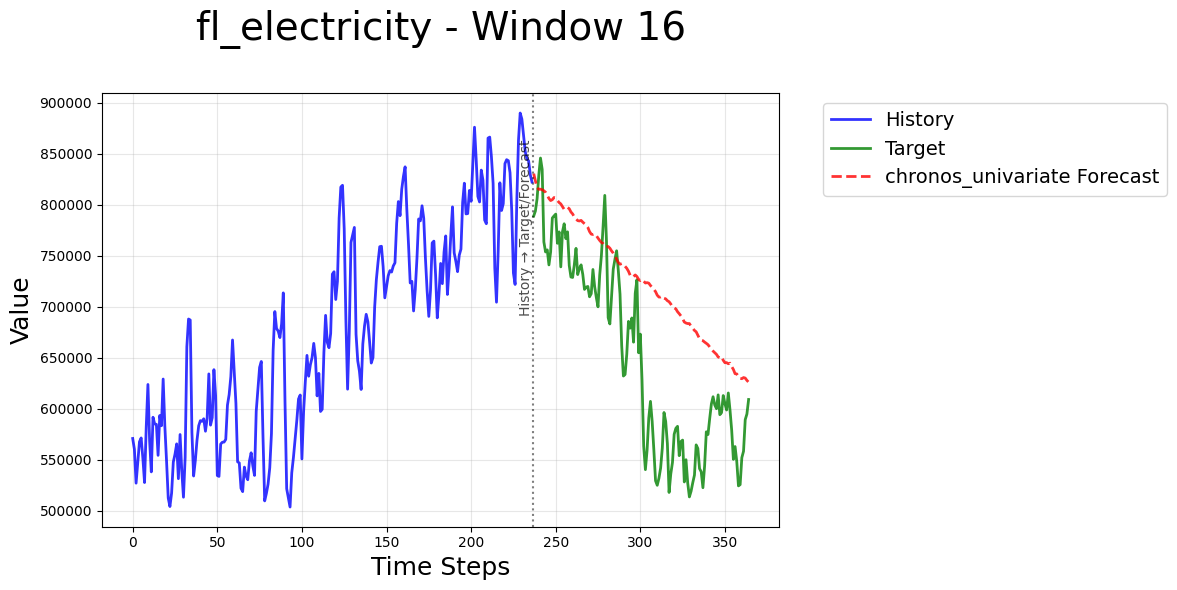

Saved plot 10: ny_electricity2025 - Window 9 to ../../museval_runs/chronos_bolt/plots/baseline_forecast_9.png
Started Processing ecl - Window 10
Plot saved to: ../../museval_runs/chronos_bolt/plots/baseline_forecast_10.png


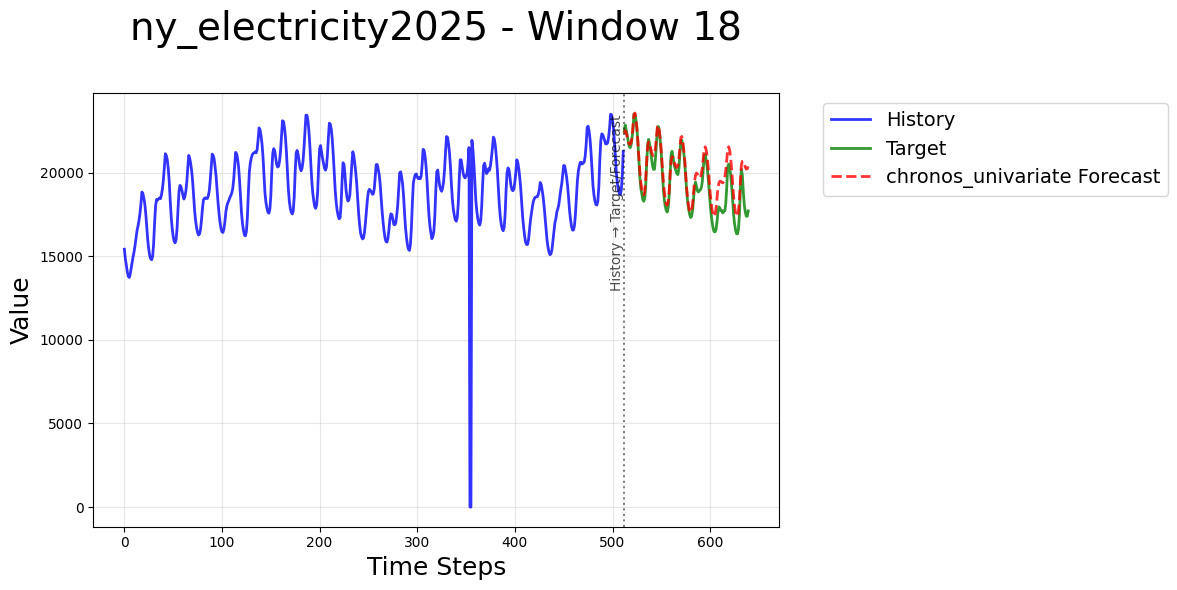

Saved plot 11: ecl - Window 10 to ../../museval_runs/chronos_bolt/plots/baseline_forecast_10.png


True

In [8]:
import copy
from museval.examples.run_museval import generate_forecast_plots

generate_forecast_plots(results, OUTPUT_DIR, limit_windows=10)

In [9]:
# Export hierarchical results to CSV
export_hierarchical_results_to_csv(results, output_dir=OUTPUT_DIR)



Exporting Hierarchical Results to CSV
✓ Cleaned directory: ../../museval_runs/chronos_bolt/categories
✓ Cleaned directory: ../../museval_runs/chronos_bolt/domains
✓ Cleaned directory: ../../museval_runs/chronos_bolt/datasets
✓ Dataset results saved: chronos_dataset_results.csv

Hierarchical CSV files saved to:
  Categories: ../../museval_runs/chronos_bolt/categories/
  Domains: ../../museval_runs/chronos_bolt/domains/
  Datasets: ../../museval_runs/chronos_bolt/datasets/


In [10]:
# Export hierarchical results to CSV using the results from the previous evaluation
export_hierarchical_results_to_csv(results, output_dir=OUTPUT_DIR)



Exporting Hierarchical Results to CSV
✓ Cleaned directory: ../../museval_runs/chronos_bolt/categories
✓ Cleaned directory: ../../museval_runs/chronos_bolt/domains
✓ Cleaned directory: ../../museval_runs/chronos_bolt/datasets
✓ Dataset results saved: chronos_dataset_results.csv

Hierarchical CSV files saved to:
  Categories: ../../museval_runs/chronos_bolt/categories/
  Domains: ../../museval_runs/chronos_bolt/domains/
  Datasets: ../../museval_runs/chronos_bolt/datasets/


In [11]:
# Display results summary
if results and 'chronos' in results:
    chronos_results = results['chronos']
    print("\nChronos Results Summary:")
    print(f"Total windows processed: {chronos_results['windows']}")
    print(f"Total time: {chronos_results['time']:.2f} seconds")
    
    if chronos_results['metrics']:
        metrics = chronos_results['metrics']
        print(f"Average MAPE: {metrics.get('MAPE', 'N/A'):.2f}%")
        print(f"Average MAE: {metrics.get('MAE', 'N/A'):.4f}")
        print(f"Average RMSE: {metrics.get('RMSE', 'N/A'):.4f}")
        print(f"Average NMAE: {metrics.get('NMAE', 'N/A'):.4f}")
    
    print(f"\nResults saved to: {OUTPUT_DIR}")
else:
    print("No results available.")



Chronos Results Summary:
Total windows processed: 169
Total time: 20.19 seconds
Average MAPE: 79.35%
Average MAE: 3704876.9923
Average RMSE: 4591719.0858
Average NMAE: 0.9195

Results saved to: ../../museval_runs/chronos_bolt


## Summary

This notebook demonstrates how to run Chronos Bolt on the MUSEval benchmark using the efficient functions from `run_museval.py`. 

### Key Benefits:

1. **Efficient**: Uses optimized evaluation functions instead of custom loops
2. **Self-contained**: ChronosForecast class defined within the notebook
3. **Comprehensive**: Generates hierarchical CSV results and performance comparisons
4. **Minimal code**: Only ~10 cells vs. hundreds of lines in custom evaluation

### Functions Used:

- `run_models_on_benchmark()`: Main evaluation function
- `compare_model_performance()`: Performance comparison
- `export_hierarchical_results_to_csv()`: Hierarchical CSV export

This approach leverages the existing, well-tested evaluation framework while keeping the notebook clean and efficient.


In [12]:
# Generate submission files for competition
from museval.examples.save_submission import save_submission

if 'chronos_results' in locals() and chronos_results:
    submission_dir = os.path.join(OUTPUT_DIR, "submissions")
    save_submission({'chronos': chronos_results}, submission_dir)
    print(f"Submission files saved to: {submission_dir}")
else:
    print("No results available for submission generation.")


Submission file saved to: ../../museval_runs/chronos_bolt/submissions/chronos_submission.json
Model: chronos
Total datasets: 86
Domains: 16
Categories: 4

Submission files saved to: ../../museval_runs/chronos_bolt/submissions
